<a href="https://colab.research.google.com/github/gabriellabc/monitoramento_agua_superficial_subterranea/blob/main/Final_%5BTCC%5D_RandomForest_Supervisionado_IQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Regressão com Spark") \
    .getOrCreate()

spark

In [ ]:
dados = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/Base de dados/IQA_calculado.csv', header=True)

In [ ]:
dados

DataFrame[Precipitação [mm]: string, DBO (5, 20) [mg/L]: string, Escherichia coli** [UFC/100mL]: string, Fósforo Total [mg/L]: string, Nitrogênio Total [mg/L]: string, Sólido Total [mg/L]: string, Temperatura da Água [ºC]: string, Turbidez [UNT]: string, pH [U.pH]: string, Oxigênio Dissolvido [mg/L]: string, IQA: string]

In [ ]:
dados.show(truncate=False)

+-----------------+------------------+------------------------------+--------------------+-----------------------+-------------------+------------------------+--------------+---------+--------------------------+------------------+
|Precipitação [mm]|DBO (5, 20) [mg/L]|Escherichia coli** [UFC/100mL]|Fósforo Total [mg/L]|Nitrogênio Total [mg/L]|Sólido Total [mg/L]|Temperatura da Água [ºC]|Turbidez [UNT]|pH [U.pH]|Oxigênio Dissolvido [mg/L]|IQA               |
+-----------------+------------------+------------------------------+--------------------+-----------------------+-------------------+------------------------+--------------+---------+--------------------------+------------------+
|200              |2.0               |18.0                          |0.05                |2.17                   |172.0              |27.3                    |65.0          |6.81     |58.39371921146193         |81.02966761427672 |
|200              |3.0               |87000.0                       |0.2    

In [ ]:
dados.count()

1783

# **Investigando os dados**

**Seleção de features**

In [ ]:
dados.printSchema()

root
 |-- Precipitação [mm]: string (nullable = true)
 |-- DBO (5, 20) [mg/L]: string (nullable = true)
 |-- Escherichia coli** [UFC/100mL]: string (nullable = true)
 |-- Fósforo Total [mg/L]: string (nullable = true)
 |-- Nitrogênio Total [mg/L]: string (nullable = true)
 |-- Sólido Total [mg/L]: string (nullable = true)
 |-- Temperatura da Água [ºC]: string (nullable = true)
 |-- Turbidez [UNT]: string (nullable = true)
 |-- pH [U.pH]: string (nullable = true)
 |-- Oxigênio Dissolvido [mg/L]: string (nullable = true)
 |-- IQA: string (nullable = true)



In [ ]:
dataset = dados

In [ ]:
dataset = dataset.withColumnRenamed("pH [U.pH]", "pH") \
                .withColumnRenamed("Precipitação [mm]", "Precipitacao") \
                .withColumnRenamed("Escherichia coli** [UFC/100mL]", "Escherichia_coli") \
                .withColumnRenamed("Fósforo Total [mg/L]", "Fosforo") \
                .withColumnRenamed("Nitrogênio Total [mg/L]", "Nitrogenio") \
                .withColumnRenamed("Oxigênio Dissolvido [mg/L]", "Oxigenio_Dissolvido") \
                .withColumnRenamed("Temperatura da Água [ºC]", "Temperatura") \
                .withColumnRenamed("Turbidez [UNT]", "Turbidez") \
                .withColumnRenamed("Sólido Total [mg/L]", "Solido") \
                .withColumnRenamed("DBO (5, 20) [mg/L]", "DBO")

In [ ]:
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql import functions as f

In [ ]:
colunas_numericas = [
    'Precipitacao',
    'DBO',
    'Escherichia_coli',
    'Fosforo',
    'Nitrogenio',
    'Oxigenio_Dissolvido',
    'Solido',
    'Temperatura',
    'Turbidez',
    'pH',
    'IQA'
]

for coluna in colunas_numericas:
    dataset = dataset.withColumn(coluna, dataset[coluna].cast(DoubleType()))

In [ ]:
dataset.printSchema()

root
 |-- Precipitacao: double (nullable = true)
 |-- DBO: double (nullable = true)
 |-- Escherichia_coli: double (nullable = true)
 |-- Fosforo: double (nullable = true)
 |-- Nitrogenio: double (nullable = true)
 |-- Solido: double (nullable = true)
 |-- Temperatura: double (nullable = true)
 |-- Turbidez: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- Oxigenio_Dissolvido: double (nullable = true)
 |-- IQA: double (nullable = true)



In [ ]:
dataset\
    .select('Precipitacao')\
    .groupBy('Precipitacao')\
    .count()\
    .show()

+------------+-----+
|Precipitacao|count|
+------------+-----+
|       170.0|   89|
|       160.0|   66|
|        70.0|   97|
|       180.0|   16|
|       280.0|   38|
|        80.0|   78|
|       120.0|   36|
|       250.0|   16|
|       210.0|   36|
|       330.0|   22|
|        50.0|   75|
|       230.0|    8|
|       400.0|   18|
|       130.0|   22|
|        60.0|  180|
|       200.0|  155|
|        10.0|  150|
|        30.0|  108|
|        40.0|   52|
|       260.0|   20|
+------------+-----+
only showing top 20 rows



In [ ]:
dataset.columns

['Precipitacao',
 'DBO',
 'Escherichia_coli',
 'Fosforo',
 'Nitrogenio',
 'Solido',
 'Temperatura',
 'Turbidez',
 'pH',
 'Oxigenio_Dissolvido',
 'IQA']

In [ ]:
dataset\
    .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dataset.columns])\
    .show()

+------------+---+----------------+-------+----------+------+-----------+--------+---+-------------------+---+
|Precipitacao|DBO|Escherichia_coli|Fosforo|Nitrogenio|Solido|Temperatura|Turbidez| pH|Oxigenio_Dissolvido|IQA|
+------------+---+----------------+-------+----------+------+-----------+--------+---+-------------------+---+
|           0|  0|               0|      0|         0|     0|          0|       0|  0|                  0|  0|
+------------+---+----------------+-------+----------+------+-----------+--------+---+-------------------+---+



**Vetorização dos dados**

In [ ]:
from pyspark.ml.feature import VectorAssembler

In [ ]:
dataset = dataset.withColumnRenamed('IQA', 'label')

In [ ]:
X = [
    'Precipitacao',
 'DBO',
 'Escherichia_coli',
 'Fosforo',
 'Nitrogenio',
 'Oxigenio_Dissolvido',
 'Solido',
 'Temperatura',
 'Turbidez',
 'pH',
]

In [ ]:
assembler = VectorAssembler(inputCols=X, outputCol='features')

In [ ]:
dataset_prep = assembler.transform(dataset).select('features', 'label')

In [ ]:
dataset_prep.show(10, truncate=False)

+---------------------------------------------------------------------+------------------+
|features                                                             |label             |
+---------------------------------------------------------------------+------------------+
|[200.0,2.0,18.0,0.05,2.17,58.39371921146193,172.0,27.3,65.0,6.81]    |81.02966761427672 |
|[200.0,3.0,87000.0,0.2,2.17,59.4786223377001,194.0,25.9,60.0,7.07]   |50.98328905512943 |
|[80.0,2.0,1340.0,0.06,2.17,56.59953131615468,106.0,24.3,50.0,6.87]   |75.52473024488863 |
|[80.0,3.0,24000.0,0.28,2.17,54.68498545883629,134.0,22.1,39.0,7.05]  |62.39667443012466 |
|[200.0,2.0,3800.0,0.06,2.17,72.99725019443471,135.0,26.5,50.0,7.19]  |73.55242195203768 |
|[200.0,6.0,79000.0,0.39,2.17,56.950447465538666,168.0,24.4,31.3,7.14]|52.403554467369254|
|[60.0,19.0,360000.0,1.0,2.17,58.71088330065247,526.0,25.0,360.0,7.0] |32.01599911624673 |
|[60.0,2.0,680.0,0.08,2.17,96.73112096057523,85.0,24.4,31.7,6.9]      |83.5177478355604  |

# **Dados de treino e teste**

In [ ]:
treino, teste = dataset_prep.randomSplit([0.7, 0.3], seed=101)

In [ ]:
treino.count()

1240

In [ ]:
teste.count()

543

# **Random Forest**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import RandomForestRegressor

In [ ]:
spark = SparkSession.builder \
    .appName("Regressão com Spark") \
    .getOrCreate()

In [ ]:
rfr = RandomForestRegressor(seed=101, maxDepth=7, numTrees=10)

In [ ]:
modelo_rfr = rfr.fit(treino)

In [ ]:
previsoes_rfr_treino = modelo_rfr.transform(treino)

In [ ]:
previsoes_rfr_treino.show()

+--------------------+-----------------+-----------------+
|            features|            label|       prediction|
+--------------------+-----------------+-----------------+
|[10.0,2.0,1.0,0.0...|87.84421734341473|84.53942118186004|
|[10.0,2.0,2.1,0.0...|93.54419951573361|86.66806443760754|
|[10.0,2.0,3.1,0.3...|90.90093880213091| 86.6807826592985|
|[10.0,2.0,22.0,0....|89.83452150038839|86.03720413675833|
|[10.0,2.0,32.0,0....|88.91241442728891|85.94899534147729|
|[10.0,2.0,46.0,0....|88.06806151235337|86.03720413675833|
|[10.0,2.0,48.0,0....|81.80474251554433| 81.0189960666749|
|[10.0,2.0,80.0,0....|88.52377155304724|86.82481259621116|
|[10.0,2.0,81.0,0....|88.28575672708226|86.61146177527901|
|[10.0,2.0,87.0,0....| 87.8847244191281|86.54292241195644|
|[10.0,2.0,90.0,0....|86.79946329597128| 85.9980052837976|
|[10.0,2.0,92.0,0....| 89.6171264943977|86.19267600713496|
|[10.0,2.0,108.0,0...|85.97073136006925|86.32957159102429|
|[10.0,2.0,120.0,0...|86.89612405760256|86.0372041367583

## **Métricas**

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")

In [ ]:
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))

0.9809054911893914
2.0259700378046577


In [ ]:
previsoes_rfr_teste = modelo_rfr.transform(teste)

In [ ]:
previsoes_rfr_teste.show()

+--------------------+-----------------+-----------------+
|            features|            label|       prediction|
+--------------------+-----------------+-----------------+
|[10.0,2.0,23.0,0....|77.08291763925925| 75.6224062954819|
|[10.0,2.0,27.0,0....|82.24732577226081|83.00064904155809|
|[10.0,2.0,97.0,0....|83.25181676833125|84.94709682344774|
|[10.0,2.0,104.0,0...|77.35300131673203|78.33896937039898|
|[10.0,2.0,124.0,0...|90.17639117330614|86.82481259621116|
|[10.0,2.0,136.0,0...|88.34554797799443|86.16234616240942|
|[10.0,2.0,140.0,0...|86.50893323629549| 86.1750643841004|
|[10.0,2.0,142.0,0...|86.93957285116606|86.66806443760754|
|[10.0,2.0,192.0,0...|85.94393419515428|86.07737743586156|
|[10.0,2.0,212.0,0...|83.07114721517472|84.36008595214949|
|[10.0,2.0,212.0,0...|88.02595553282634|86.82481259621116|
|[10.0,2.0,280.0,0...| 87.4269780438346|86.31781803278606|
|[10.0,2.0,310.0,0...|86.36356295198401|85.57016125634604|
|[10.0,2.0,400.0,0...|80.81763491551862|81.0520556119539

In [ ]:
previsoes_rfr_teste.describe()

DataFrame[summary: string, label: string, prediction: string]

In [ ]:
print('Random Forest Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))

Random Forest Regression
Dados de Treino
R²: 0.980905
RMSE: 2.025970

Dados de Teste
R²: 0.966685
RMSE: 2.814275


In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor


In [ ]:
rfr = RandomForestRegressor()

In [ ]:
grid = ParamGridBuilder() \
    .addGrid(rfr.numTrees, [10, 20, 30]) \
    .addGrid(rfr.maxDepth, [5, 10]) \
    .addGrid(rfr.maxBins, [10, 32, 45]) \
    .build()

In [ ]:
evaluator = RegressionEvaluator()

In [ ]:
rfr_cv = CrossValidator(
    estimator=rfr,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3
)

In [ ]:
modelo_rfr_cv = rfr_cv.fit(treino)

In [ ]:
previsoes_rfr_cv_teste = modelo_rfr_cv.transform(teste)

In [ ]:
print('Random Forest')
print("="*30)
print("Sem Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Com Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "rmse"}))

Random Forest
Sem Cross Validation
R²: 0.966685
RMSE: 2.814275

Com Cross Validation
R²: 0.976235
RMSE: 2.376919


## **Prevendo resultados**

In [ ]:
X

['Precipitacao',
 'DBO',
 'Escherichia_coli',
 'Fosforo',
 'Nitrogenio',
 'Oxigenio_Dissolvido',
 'Solido',
 'Temperatura',
 'Turbidez',
 'pH']

In [ ]:
novos_parametros = [{
    'Precipitacao': 42,
    'DBO': 10,
    'Escherichia_coli': 15000,
    'Fosforo': 2.1,
    'Nitrogenio': 4.2,
    'Oxigenio_Dissolvido': 6,
    'Solido': 110,
    'Temperatura': 14,
    'Turbidez': 182,
    'pH': 7,
    'label': 0
    }]

In [ ]:
novos_parametros = spark.createDataFrame(novos_parametros)

In [ ]:
novos_parametros.show()

+---+----------------+-------+----------+-------------------+------------+------+-----------+--------+-----+---+
|DBO|Escherichia_coli|Fosforo|Nitrogenio|Oxigenio_Dissolvido|Precipitacao|Solido|Temperatura|Turbidez|label| pH|
+---+----------------+-------+----------+-------------------+------------+------+-----------+--------+-----+---+
| 10|           15000|    2.1|       4.2|                  6|          42|   110|         14|     182|    0|  7|
+---+----------------+-------+----------+-------------------+------------+------+-----------+--------+-----+---+



In [ ]:
assembler = VectorAssembler(inputCols = X, outputCol = 'features')

In [ ]:
novos_parametros_vetorizado = assembler.transform(novos_parametros).select('features')

from pyspark.sql.functions import lit
novos_parametros_vetorizado = novos_parametros_vetorizado.withColumn('label', lit(0))

In [ ]:
novos_parametros

DataFrame[DBO: bigint, Escherichia_coli: bigint, Fosforo: double, Nitrogenio: double, Oxigenio_Dissolvido: bigint, Precipitacao: bigint, Solido: bigint, Temperatura: bigint, Turbidez: bigint, label: bigint, pH: bigint]

In [ ]:
novos_parametros.show()

+---+----------------+-------+----------+-------------------+------------+------+-----------+--------+-----+---+
|DBO|Escherichia_coli|Fosforo|Nitrogenio|Oxigenio_Dissolvido|Precipitacao|Solido|Temperatura|Turbidez|label| pH|
+---+----------------+-------+----------+-------------------+------------+------+-----------+--------+-----+---+
| 10|           15000|    2.1|       4.2|                  6|          42|   110|         14|     182|    0|  7|
+---+----------------+-------+----------+-------------------+------------+------+-----------+--------+-----+---+



In [ ]:
assembler = VectorAssembler(inputCols = X, outputCol = 'features')
novos_parametros = assembler.transform(novos_parametros).select('features','label')
modelo_rfr_cv.transform(novos_parametros).show()

+--------------------+-----+-----------------+
|            features|label|       prediction|
+--------------------+-----+-----------------+
|[42.0,10.0,15000....|    0|48.86582328073818|
+--------------------+-----+-----------------+



In [ ]:
importances = modelo_rfr_cv.bestModel.featureImportances

feature_importances = pd.DataFrame({'Feature': X, 'Importance': importances.toArray()})
feature_importances = feature_importances.sort_values('Importance', ascending=False)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

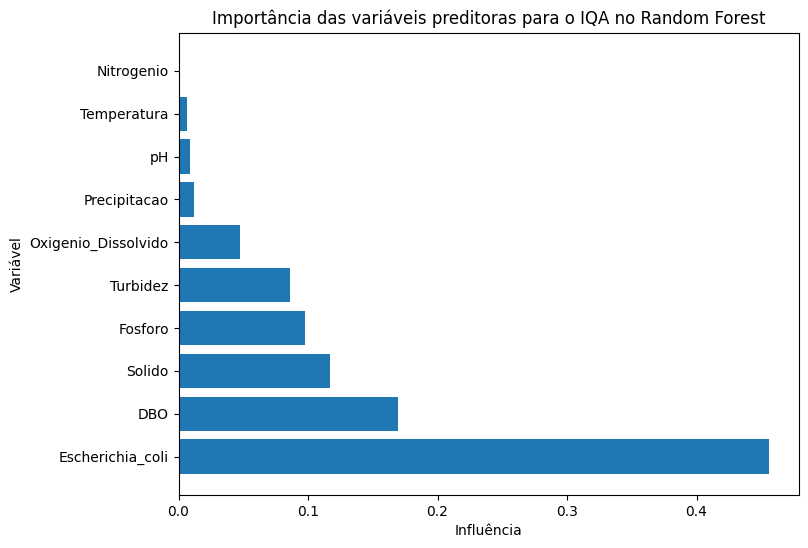

In [ ]:
plt.figure(figsize=(8, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Influência')
plt.ylabel('Variável')
plt.title('Importância das variáveis preditoras para o IQA no Random Forest')
plt.show()

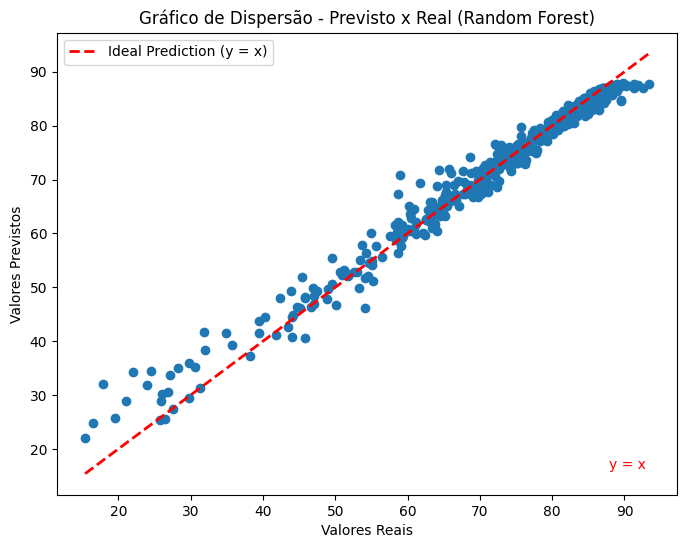

In [ ]:
import numpy as np

plt.figure(figsize=(8, 6))

previsoes_rfr_cv_teste = modelo_rfr_cv.transform(teste)

y_test = previsoes_rfr_cv_teste.select("label").toPandas()
y_pred = previsoes_rfr_cv_teste.select("prediction").toPandas()

x = np.linspace(y_test.min(), y_test.max(), 100)
plt.plot(x, x, color='red', linestyle='--', lw=2, label='Ideal Prediction (y = x)')

plt.text(0.95, 0.05, 'y = x', transform=plt.gca().transAxes, ha='right', va='bottom', color='red')

plt.scatter(y_test, y_pred)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.title('Gráfico de Dispersão - Previsto x Real (Random Forest)')
plt.legend()
plt.show()